Found 435 images belonging to 2 classes.
Found 108 images belonging to 2 classes.
Class Weights: {0: 1.0406698564593302, 1: 0.9623893805309734}
Epoch 1/20
14/14 [==============================] - 81s 5s/step - loss: 0.6721 - accuracy: 0.5563 - val_loss: 0.7080 - val_accuracy: 0.4815
Epoch 2/20
14/14 [==============================] - 58s 4s/step - loss: 0.6648 - accuracy: 0.6322 - val_loss: 0.7032 - val_accuracy: 0.4815
Epoch 3/20
14/14 [==============================] - 57s 4s/step - loss: 0.6303 - accuracy: 0.6759 - val_loss: 0.7021 - val_accuracy: 0.4815
Epoch 4/20
14/14 [==============================] - 57s 4s/step - loss: 0.6169 - accuracy: 0.6920 - val_loss: 0.7023 - val_accuracy: 0.4815
Epoch 5/20
14/14 [==============================] - 59s 4s/step - loss: 0.5891 - accuracy: 0.7356 - val_loss: 0.6979 - val_accuracy: 0.4815
Epoch 6/20
14/14 [==============================] - 60s 4s/step - loss: 0.5898 - accuracy: 0.7241 - val_loss: 0.6944 - val_accuracy: 0.4815
Epoch 7/20
14/14

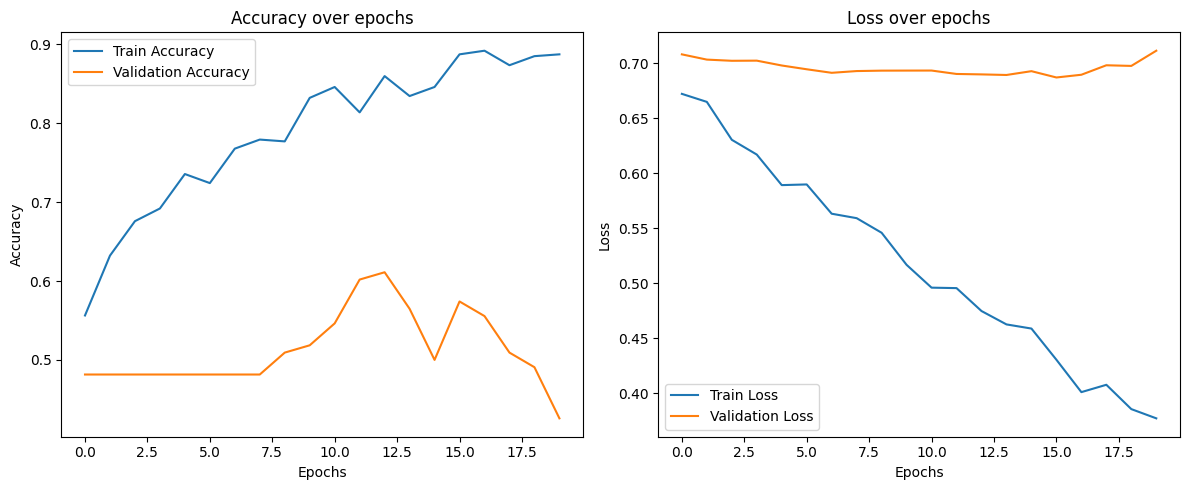

4/4 [==============================] - 6s 830ms/step


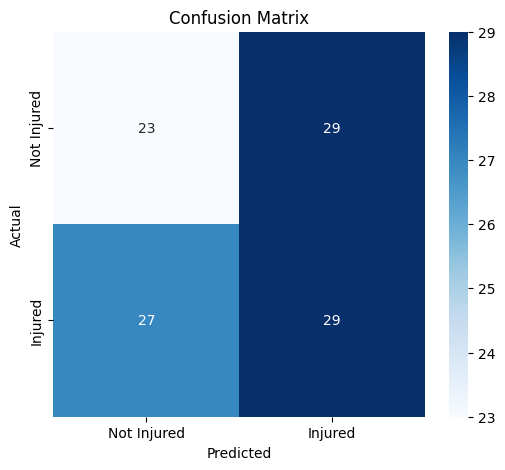

              precision    recall  f1-score   support

 Not Injured       0.46      0.44      0.45        52
     Injured       0.50      0.52      0.51        56

    accuracy                           0.48       108
   macro avg       0.48      0.48      0.48       108
weighted avg       0.48      0.48      0.48       108



In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# 📁 Prétraitement et data augmentation améliorée
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    brightness_range=[0.7, 1.3]
)

train_gen = train_datagen.flow_from_directory(
    '../dataset_corrige_animals/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    '../dataset_corrige_animals/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

# 📊 Calcul des class_weights pour gérer le déséquilibre
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# 📦 Charger EfficientNetB0 pré-entraîné
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Dé-geler les 50 dernières couches pour fine-tuning
for layer in base_model.layers[-50:]:
    layer.trainable = True

# ⚙️ Compilation avec learning rate ajusté
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# 📊 Entraînement
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    class_weight=class_weights
)

# 📈 Courbes Loss & Accuracy
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 📊 Prédictions sur validation
val_gen.reset()
preds = model.predict(val_gen)
pred_classes = (preds > 0.5).astype(int).reshape(-1)

# 📉 Matrice de confusion
cm = confusion_matrix(val_gen.classes, pred_classes)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Not Injured', 'Injured'], 
            yticklabels=['Not Injured', 'Injured'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 📄 Rapport de classification
target_names = ['Not Injured', 'Injured']
report = classification_report(val_gen.classes, pred_classes, target_names=target_names)
print(report)